In [1]:
## importar bibliotecas

#!pip install investpy
#pip install yfinance

In [2]:
## Importar as bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import investpy as inv
import seaborn as sn
from scipy.optimize import Bounds
from scipy.optimize import minimize

In [3]:
## Buscar ativos brasileiros
stocks_br = inv.stocks.get_stocks(country='brazil')

In [4]:
## Corrigir nome dos ativos para a biblioteca yfinance
portfolio = []
for a in stocks_br['symbol']:
        portfolio.append(a+'.SA')

In [5]:
## Definir prazo intervalo de tempo da amostra
start_date = '2022-01-01' #formato 'YYYY-MM-DD'
end_date = '2022-06-30'   #formato 'YYYY-MM-DD'

In [6]:
## Baixar o valor de fechamento de todos os ativos
dt1=yf.download(portfolio,start='2022-01-01', end='2022-06-30')['Adj Close']


[*********************100%%**********************]  747 of 747 completed

167 Failed downloads:
['UTEC34.SA', 'TCNO3.SA', 'PARD3.SA', 'LCAM3.SA', 'CELP6.SA', 'VIVT4.SA', 'NVIF11B.SA', 'CESP5.SA', 'BRHT11B.SA', 'MMXM3.SA', 'GESE11B.SA', 'BTTL3.SA', 'BEEF11.SA', 'ELEK3.SA', 'ATCR11.SA', 'EEEL4.SA', 'GNDI3.SA', 'CCXC3.SA', 'SPRN34.SA', 'SPAF11.SA', 'XTED11.SA', 'VLJS11.SA', 'BIDI3.SA', 'SFND11.SA', 'NATU3.SA', 'CARD3.SA', 'SULA11.SA', 'PRTS11.SA', 'PCAR4.SA', 'AVON34.SA', 'CPRE3.SA', 'CELP7.SA', 'TIET4.SA', 'VPSI11.SA', 'BMLC11B.SA', 'TIET11.SA', 'ITEC3.SA', 'TRXL11.SA', 'SPRI3.SA', 'ELDO11B.SA', 'BKBR3.SA', 'TASA17.SA', 'TCR11.SA', 'BSEV3.SA', 'XPHT12.SA', 'ENMA3B.SA', 'CCPR3.SA', 'JRDM11.SA', 'BBRK3.SA', 'SMLS3T.SA', 'OUCY11.SA', 'CRDE3.SA', 'SQIA3.SA', 'GBIO33.SA', 'TESA3.SA', 'TIET3.SA', 'MYPK12.SA', 'JCPC34.SA', 'WIZS3.SA', 'CELP3.SA', 'BIDI4T.SA', 'SEDU3.SA', 'ESUD11.SA', 'TIMP3.SA', 'MTIG4.SA', 'TASA15.SA', 'BRDT3.SA', 'DMMO3T.SA', 'JBDU4.SA', 'LBRN34.SA', 'BRML3.SA', 'CLGN34.SA', 

In [7]:

## eliminar Colunas e linhas com NaN (finais de semana e ativos que não são mais negociáveis)
df = dt1.dropna(axis=1, how='all') 
df2 = df.dropna(thresh=100)


In [8]:
## Obter o retorno de cada ativo, e eliminar a primeira linha vazia
df_ret = df2.pct_change()*100
retorno = df_ret.dropna()


In [9]:
## Obter o retorno médio por ativos, e remover os ativos que tenham retorno médio abaixo de 0,1
options = pd.DataFrame(retorno.mean())
z = options[options>0.1].dropna().sort_values([0],ascending=False)


In [10]:
## Obter a tabela de retorno com os ativos com retorno positivo
retorno = retorno[z.index]

In [11]:
## Definir os parâmetros
QTD_ASSETS = 10
TAM_TRAIN = len(retorno.index)
QTD_PONTOS_FRONT = 400
PONTOS_FRONT = np.linspace(0, 1, QTD_PONTOS_FRONT)

In [12]:
## Definir Limites
bounds = Bounds(np.zeros(QTD_ASSETS), np.ones(QTD_ASSETS))

In [13]:
## Defini os 10 primeiros assets como os assets a serem utilizados
retornos = retorno[retorno.columns[:QTD_ASSETS]]


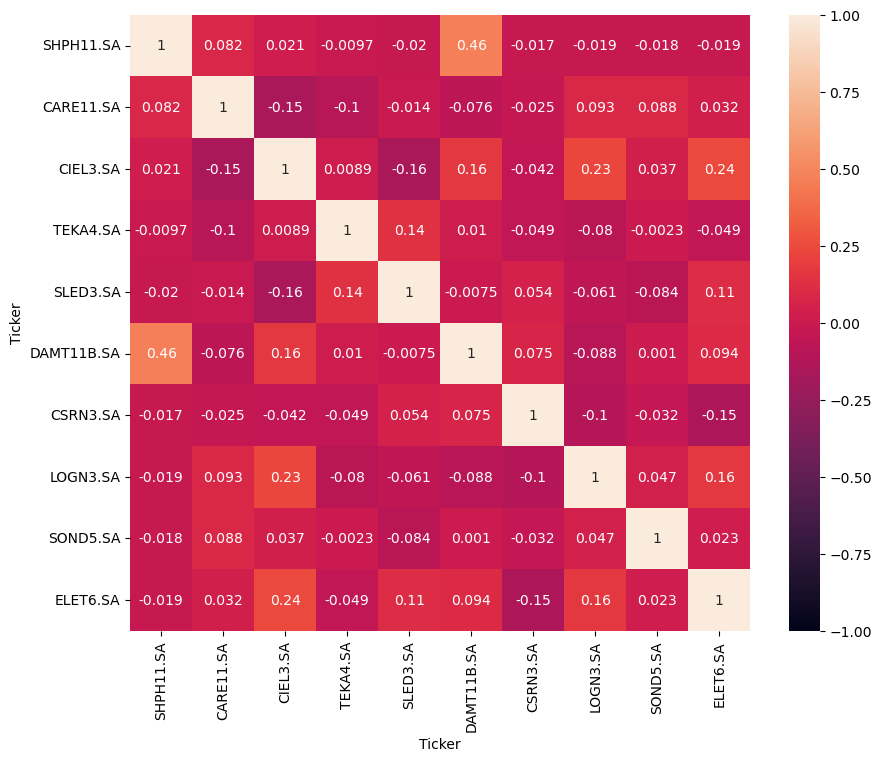

In [14]:
## Verificar a correlção entre os ativos
fig, ax = plt.subplots(figsize=(10, 8))
ax = sn.heatmap(retornos.corr(),vmin=-1, vmax=1, annot=True)
retornos.corr().unstack().sort_values() 
plt.show()

In [15]:
## Algum parametros iniciais A e b da equação linear
A = np.ones(QTD_ASSETS)
b = np.array([1])

In [16]:
## Definir limites
cons = [{"type": "ineq", "fun": lambda x: A @ x - b}, {"type": "ineq", "fun": lambda x: -A @ x + b}]
U0 = 1/QTD_ASSETS*np.ones(QTD_ASSETS)

In [17]:
## definir função get_optimize

def get_optimize(aux_ponto_front):
    
    def f(U,ponto_front = aux_ponto_front):
        retorno_treinamento=retornos[0:TAM_TRAIN-1]
        retorno_medio = retorno_treinamento.mean()
        retorno_carteira = retorno_medio.values.dot(U)
        risco_carteira = (U.dot(np.cov(retorno_treinamento.T))).dot(U)
        return ponto_front*risco_carteira-(1-ponto_front)*retorno_carteira

    Umin = minimize(f, U0, args=(),method='SLSQP',  jac=None, bounds=bounds, constraints=cons, 
                    tol=None,callback=None,options={'maxiter': 1000, 'ftol': 1e-16, 'iprint': 0,'eps': 1e-8})    
    return Umin.x

In [18]:
## definir função get_retorno_risco

def get_retorno_risco(carteira):
    retorno_treinamento=retornos[0:TAM_TRAIN-1]
    retorno_medio = retorno_treinamento.mean()
    retorno_carteira = retorno_medio.values.dot(carteira)
    risco_carteira = (carteira.dot(np.cov(retorno_treinamento.T))).dot(carteira)
    return retorno_carteira, risco_carteira

In [19]:
## definir função get_pareto_front

def get_pareto_front():
    carteiras_front = []
    for ponto_front in PONTOS_FRONT:
        carteira = get_optimize(ponto_front)
        carteiras_front.append(carteira)
    retorno = np.zeros(QTD_PONTOS_FRONT)
    risco = np.zeros(QTD_PONTOS_FRONT)
    for i in range(QTD_PONTOS_FRONT):
        retorno[i], risco[i] = get_retorno_risco(carteiras_front[i])
    return retorno,risco, carteiras_front

In [20]:
## Receber retorno, risco e cateira

retorno,risco, carteira  = get_pareto_front()

In [21]:
## Montar o df da carteira

carteira_df = pd.DataFrame(carteira, columns=retornos.columns)
carteira_df

Ticker,SHPH11.SA,CARE11.SA,CIEL3.SA,TEKA4.SA,SLED3.SA,DAMT11B.SA,CSRN3.SA,LOGN3.SA,SOND5.SA,ELET6.SA
0,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.611952e-16,0.000000e+00
1,0.239504,0.760496,3.693434e-15,2.508332e-17,1.767674e-17,2.881059e-19,5.559957e-17,7.680722e-17,1.126321e-16,1.600995e-16
2,0.155873,0.613943,2.301843e-01,2.002895e-16,2.911482e-16,2.397181e-16,1.582024e-16,4.016419e-17,5.306841e-17,1.252432e-17
3,0.122082,0.540417,3.375006e-01,9.064227e-17,1.183312e-16,1.416831e-16,3.475151e-17,4.431185e-17,3.970474e-17,4.911136e-17
4,0.105187,0.503655,3.911588e-01,9.064392e-17,1.624210e-16,6.317767e-17,7.907857e-17,4.608773e-17,2.556871e-17,5.836488e-18
...,...,...,...,...,...,...,...,...,...,...
395,0.011107,0.069423,4.443673e-02,8.929216e-02,8.381831e-03,2.328511e-02,1.684865e-01,2.570171e-01,1.066041e-01,2.219661e-01
396,0.011103,0.069392,4.439670e-02,8.929047e-02,8.378947e-03,2.328585e-02,1.684913e-01,2.570378e-01,1.066266e-01,2.219972e-01
397,0.011099,0.069361,4.435685e-02,8.928879e-02,8.376072e-03,2.328658e-02,1.684959e-01,2.570585e-01,1.066491e-01,2.220281e-01
398,0.011095,0.069331,4.431721e-02,8.928711e-02,8.373213e-03,2.328731e-02,1.685006e-01,2.570790e-01,1.066715e-01,2.220589e-01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


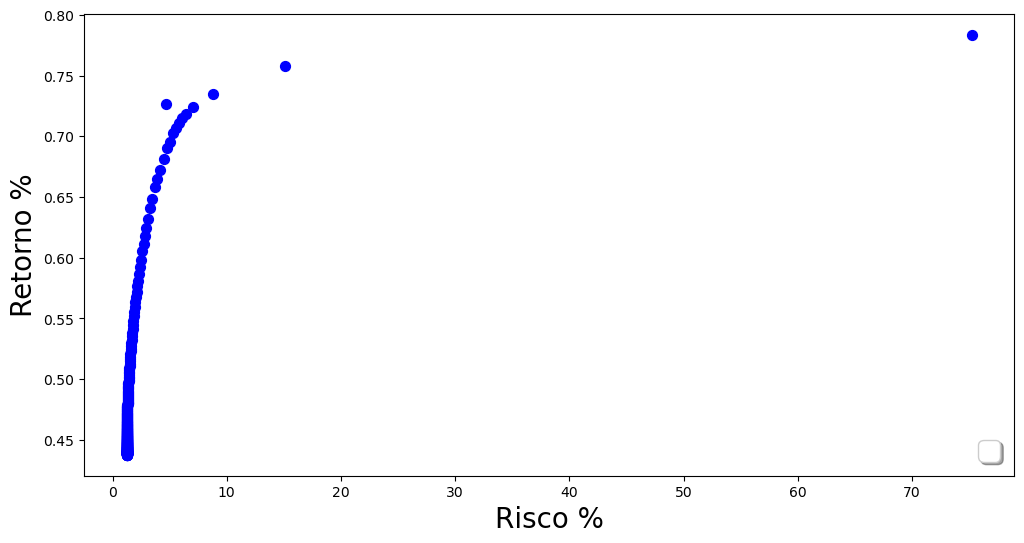

In [22]:
## Plotar o gráfico de risco e retorno

plt.figure(figsize = (12,6))
plt.scatter(risco,retorno,marker='.',s=200,c="b")
plt.xlabel('Risco %', fontsize=20)
plt.ylabel('Retorno %', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True, fontsize=20, ncol = 2)
plt.show()